# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

Trained with an updated model architecture, CNNMFCCs2


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_2'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Import EarlyStopping class


In [9]:
from models.EarlyStopping import EarlyStopping

Define what happens in each epoch


In [10]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    early_stopper = EarlyStopping(path=f'earlystop_{MODEL}.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best validation accuracy model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

        # Check for early stopping (based on val_loss)
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [11]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [13]:
from CNNMFCCs2 import CNNMFCCs2

model = CNNMFCCs2()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs2(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [14]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.99it/s, Loss=1.1162188053131104, Elapsed=1.4604s, ETA=0.0000s]

Epoch 1 completed in 7.5474s
Train Loss: 1.4359170415497928 - Train Accuracy: 38.4251826055494
Validation Loss: 1.1841618084907533 - Validation Accuracy: 47.25622625580414

Epoch 2/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.64it/s, Loss=1.069583773612976, Elapsed=1.3788s, ETA=0.0000s] 

Epoch 2 completed in 6.7871s
Train Loss: 1.1323395150934341 - Train Accuracy: 49.70715271025078
Validation Loss: 1.0263788644472758 - Validation Accuracy: 54.27395525538202

Epoch 3/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 72.16it/s, Loss=0.7769536375999451, Elapsed=1.3268s, ETA=0.0000s]

Epoch 3 completed in 6.6365s
Train Loss: 1.0141184900192857 - Train Accuracy: 54.878903688292894
Validation Loss: 0.9330121564865113 - Validation Accuracy: 57.52427184466019

Epoch 4/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.67it/s, Loss=0.6971108913421631, Elapsed=1.5386s, ETA=0.0000s]

Epoch 4 completed in 7.0473s
Train Loss: 0.9482767016901447 - Train Accuracy: 57.94758146581941
Validation Loss: 0.8828833842277527 - Validation Accuracy: 61.37610806247362

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.24it/s, Loss=0.8894945979118347, Elapsed=1.4360s, ETA=0.0000s]

Epoch 5 completed in 6.6970s
Train Loss: 0.8990933235325566 - Train Accuracy: 60.35367811673187
Validation Loss: 0.8602867547671 - Validation Accuracy: 63.08569016462643

Epoch 6/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.00it/s, Loss=0.7274580597877502, Elapsed=1.4337s, ETA=0.0000s]


Epoch 6 completed in 6.6752s
Train Loss: 0.8647310711400358 - Train Accuracy: 61.59064697768029
Validation Loss: 0.8553254302342733 - Validation Accuracy: 62.357534824820604

Epoch 7/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.35it/s, Loss=0.6598516702651978, Elapsed=1.5387s, ETA=0.0000s]

Epoch 7 completed in 6.9308s
Train Loss: 0.8238406634399656 - Train Accuracy: 63.59195857171932
Validation Loss: 0.8510124985376993 - Validation Accuracy: 63.32840861122837

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.07it/s, Loss=0.7186920046806335, Elapsed=1.4920s, ETA=0.0000s]

Epoch 8 completed in 6.8143s
Train Loss: 0.8014706988210623 - Train Accuracy: 64.35630130480993
Validation Loss: 0.8267535599072774 - Validation Accuracy: 63.62389193752638

Epoch 9/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.68it/s, Loss=0.3939562141895294, Elapsed=1.4025s, ETA=0.0000s]

Epoch 9 completed in 6.6364s
Train Loss: 0.7746608740504767 - Train Accuracy: 65.63171343931616
Validation Loss: 0.8331056567033132 - Validation Accuracy: 63.51836217813423

EarlyStopping counter: 1/5
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.53it/s, Loss=0.38867348432540894, Elapsed=1.4397s, ETA=0.0000s]


Epoch 10 completed in 6.5404s
Train Loss: 0.7572125229187784 - Train Accuracy: 66.40284027950521
Validation Loss: 0.7803587039311727 - Validation Accuracy: 64.10932883073026

Epoch 11/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.78it/s, Loss=0.4583030939102173, Elapsed=1.4215s, ETA=0.0000s]


Epoch 11 completed in 6.5003s
Train Loss: 0.736026624034595 - Train Accuracy: 67.09255783451302
Validation Loss: 0.7968815072377523 - Validation Accuracy: 65.57619248628113

EarlyStopping counter: 1/5
Epoch 12/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.02it/s, Loss=0.24342799186706543, Elapsed=1.4433s, ETA=0.0000s]

Epoch 12 completed in 6.5218s
Train Loss: 0.7219543966943818 - Train Accuracy: 67.80262771081613
Validation Loss: 0.734885778427124 - Validation Accuracy: 67.41241029970452

Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.35it/s, Loss=0.31284618377685547, Elapsed=1.4821s, ETA=0.0000s]

Epoch 13 completed in 6.7238s
Train Loss: 0.7042871594773552 - Train Accuracy: 68.55566359874268
Validation Loss: 0.7355444900194804 - Validation Accuracy: 66.51540734487126

EarlyStopping counter: 1/5
Epoch 14/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.87it/s, Loss=0.40136149525642395, Elapsed=1.4497s, ETA=0.0000s]

Epoch 14 completed in 6.8467s
Train Loss: 0.6931179496594247 - Train Accuracy: 68.9762782388458
Validation Loss: 0.7278969657421112 - Validation Accuracy: 69.48079358379063

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.93it/s, Loss=0.308669775724411, Elapsed=1.4397s, ETA=0.0000s]  


Epoch 15 completed in 6.5746s
Train Loss: 0.67126069222227 - Train Accuracy: 69.88308722100359
Validation Loss: 0.739516038497289 - Validation Accuracy: 67.32798649219079

EarlyStopping counter: 1/5
Epoch 16/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 67.58it/s, Loss=0.15561731159687042, Elapsed=1.3666s, ETA=0.0000s]

Epoch 16 completed in 6.4367s
Train Loss: 0.6612091842242059 - Train Accuracy: 70.25847448045046
Validation Loss: 0.7247311093409856 - Validation Accuracy: 67.53904601097508

Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.30it/s, Loss=0.32240986824035645, Elapsed=1.3662s, ETA=0.0000s]

Epoch 17 completed in 6.8166s
Train Loss: 0.6467867434197079 - Train Accuracy: 70.90070328576921
Validation Loss: 0.7377075346310934 - Validation Accuracy: 68.73153229210638

EarlyStopping counter: 1/5
Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.00it/s, Loss=0.28354865312576294, Elapsed=1.3707s, ETA=0.0000s]

Epoch 18 completed in 6.7187s
Train Loss: 0.6365473419427872 - Train Accuracy: 71.2444313787567
Validation Loss: 0.7118922770023346 - Validation Accuracy: 71.62304769945125

Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 72.44it/s, Loss=0.209908589720726, Elapsed=1.3469s, ETA=0.0000s]  

Epoch 19 completed in 6.5077s
Train Loss: 0.6256183900929599 - Train Accuracy: 71.90022839827232
Validation Loss: 0.7034703344106674 - Validation Accuracy: 71.69691853102574

Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.09it/s, Loss=0.26916083693504333, Elapsed=1.4207s, ETA=0.0000s]

Epoch 20 completed in 6.5287s
Train Loss: 0.6122590874488643 - Train Accuracy: 72.45426381131136
Validation Loss: 0.7074754925568899 - Validation Accuracy: 71.16926973406501

EarlyStopping counter: 1/5
Epoch 21/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.76it/s, Loss=0.19679516553878784, Elapsed=1.4286s, ETA=0.0000s]

Epoch 21 completed in 6.7960s
Train Loss: 0.6063054365057476 - Train Accuracy: 72.36154768096605
Validation Loss: 0.7043570868174235 - Validation Accuracy: 69.9556775010553

EarlyStopping counter: 2/5
Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.45it/s, Loss=0.32274001836776733, Elapsed=1.5181s, ETA=0.0000s]

Epoch 22 completed in 6.7695s
Train Loss: 0.5939426656403294 - Train Accuracy: 72.89296940367699
Validation Loss: 0.7214798625310263 - Validation Accuracy: 72.56226255804137

EarlyStopping counter: 3/5
Epoch 23/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.85it/s, Loss=0.11746399849653244, Elapsed=1.5805s, ETA=0.0000s]

Epoch 23 completed in 6.7158s
Train Loss: 0.5852620127917714 - Train Accuracy: 73.26609529409104
Validation Loss: 0.7491809359192848 - Validation Accuracy: 66.87420852680455

EarlyStopping counter: 4/5
Epoch 24/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.43it/s, Loss=0.3348686397075653, Elapsed=1.4477s, ETA=0.0000s] 

Epoch 24 completed in 6.8391s
Train Loss: 0.5773017142032613 - Train Accuracy: 73.64826666063635
Validation Loss: 0.6869168857733409 - Validation Accuracy: 72.46728577458843

Epoch 25/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.03it/s, Loss=0.1833432912826538, Elapsed=1.3749s, ETA=0.0000s] 

Epoch 25 completed in 6.5211s
Train Loss: 0.5633109014675107 - Train Accuracy: 74.15255195495352
Validation Loss: 0.7084579491615295 - Validation Accuracy: 71.58083579569438

EarlyStopping counter: 1/5
Epoch 26/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.50it/s, Loss=0.21122629940509796, Elapsed=1.4781s, ETA=0.0000s]

Epoch 26 completed in 6.5763s
Train Loss: 0.5511626104226691 - Train Accuracy: 74.78347391510822
Validation Loss: 0.7071840808788935 - Validation Accuracy: 71.3064584212748

EarlyStopping counter: 2/5
Epoch 27/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.27it/s, Loss=0.13425379991531372, Elapsed=1.5134s, ETA=0.0000s]

Epoch 27 completed in 6.6069s
Train Loss: 0.5480920600925567 - Train Accuracy: 74.53246195246602
Validation Loss: 0.7112391177813212 - Validation Accuracy: 71.97129590544533

EarlyStopping counter: 3/5
Epoch 28/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.42it/s, Loss=0.14742659032344818, Elapsed=1.4825s, ETA=0.0000s]

Epoch 28 completed in 6.8852s
Train Loss: 0.5365144797315488 - Train Accuracy: 75.12041790099727
Validation Loss: 0.7167281999190649 - Validation Accuracy: 72.26677923174336

EarlyStopping counter: 4/5
Epoch 29/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.40it/s, Loss=0.18678663671016693, Elapsed=1.4730s, ETA=0.0000s]


Epoch 29 completed in 6.7221s
Train Loss: 0.5305645894797552 - Train Accuracy: 75.45962325591913
Validation Loss: 0.72637795428435 - Validation Accuracy: 70.65217391304348

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


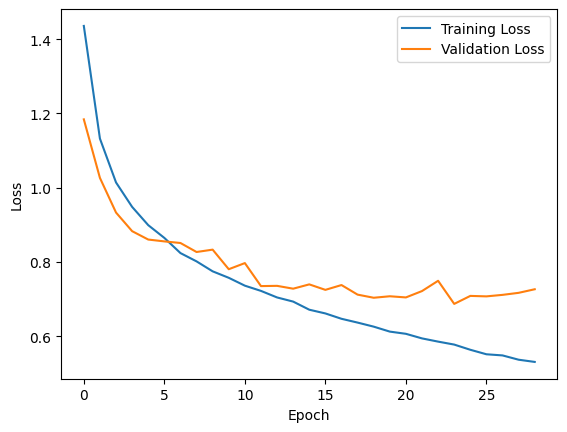

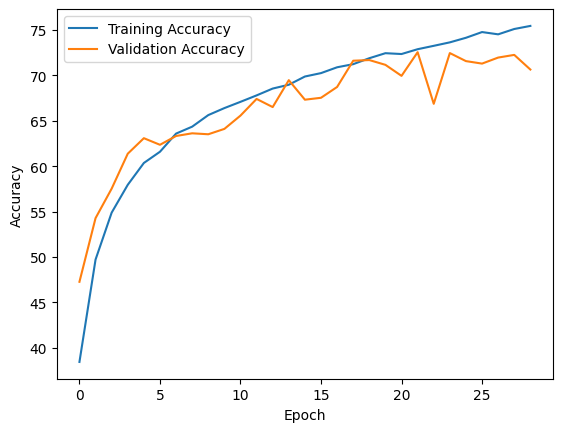

In [16]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [18]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 45.73it/s]


Test Accuracy: 0.7139
Test Precision: 0.7300
Test Recall: 0.7139
Test F1-score: 0.7135

              precision    recall  f1-score   support

       Anger       0.80      0.74      0.77       916
       Bored       0.68      0.92      0.78      1098
     Disgust       0.56      0.65      0.60       291
        Fear       0.41      0.74      0.52       308
       Happy       0.81      0.57      0.67      1914
     Neutral       0.68      0.64      0.66      2226
    Question       0.81      0.85      0.83      1139
         Sad       0.76      0.74      0.75       857
    Surprise       0.70      0.76      0.73       728

    accuracy                           0.71      9477
   macro avg       0.69      0.73      0.70      9477
weighted avg       0.73      0.71      0.71      9477



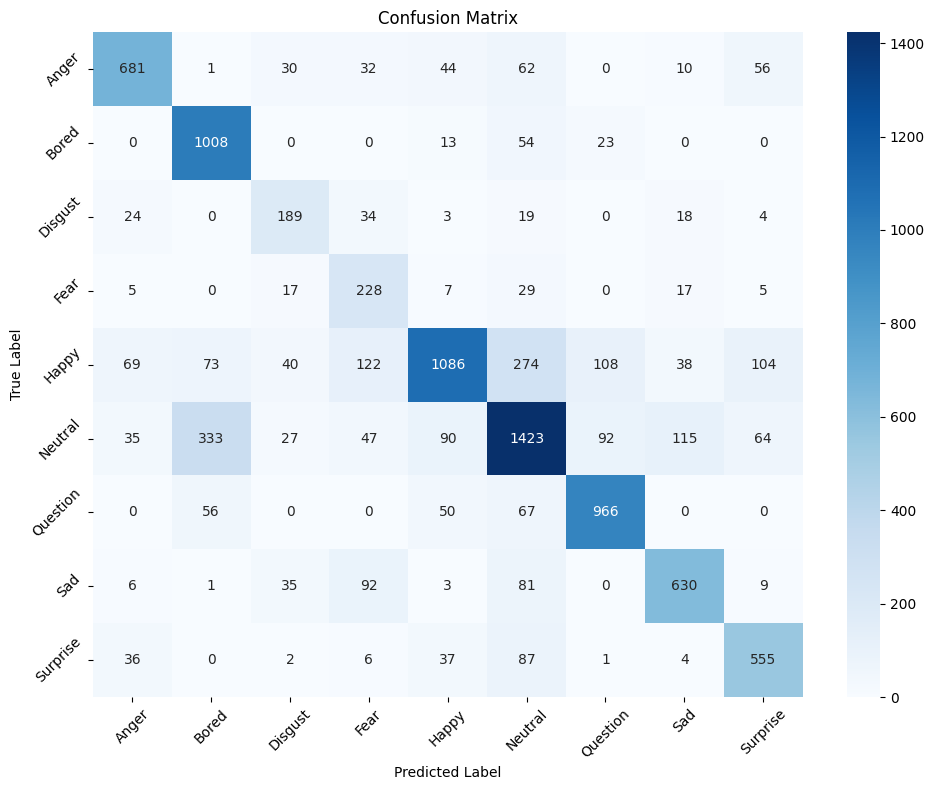

In [20]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)